In [23]:
#CW
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2

In [24]:
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    plt.figure()
        
    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img
    
    l0=np.where(difference!=0)[0].shape[0]
    l2=np.linalg.norm(difference)
    #print(difference)
    print("l0={} l2={}".format(l0,l2))
    
    #(-1,1)  -> (0,1)
    difference=difference / abs(difference).max()/2.0+0.5
    
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [25]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
image_path="picture/cropped_panda.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()


(1, 3, 224, 224)


In [26]:
#adam的最大迭代次数 论文中建议10000次 测试阶段1000也可以 1000次可以完成95%的优化工作
max_iterations=1000
#adam学习速率
learning_rate=0.01
#二分查找最大次数
binary_search_steps=10
#c的初始值
initial_const=1
confidence=initial_const

#k值
k=40

#像素值区间
boxmin = -3.0
boxmax = 3.0

#类别数 pytorch的实现里面是1000
num_labels=1000

#攻击目标标签 必须使用one hot编码
target_label=288
tlab=Variable(torch.from_numpy(np.eye(num_labels)[target_label]).to(device).float())


print()

shape = (1,3,224,224)


In [27]:


#c的初始化边界
lower_bound = 0
c=initial_const
upper_bound = 1e10

# the best l2, score, and image attack
o_bestl2 = 1e10
o_bestscore = -1
o_bestattack = [np.zeros(shape)]



In [28]:
import torch.nn.functional as F

# the resulting image, tanh'd to keep bounded from boxmin to boxmax
boxmul = (boxmax - boxmin) / 2.
boxplus = (boxmin + boxmax) / 2.

for outer_step in range(binary_search_steps):
    print("o_bestl2={} confidence={}".format(o_bestl2,confidence)  )
    
    #把原始图像转换成图像数据和扰动的形态
    timg = Variable(torch.from_numpy(np.arctanh((img - boxplus) / boxmul * 0.999999)).to(device).float())
    modifier=Variable(torch.zeros_like(timg).to(device).float())
    

    #设置为不保存梯度值 自然也无法修改
    #for param in model.parameters():
    #    param.requires_grad = False
        
    #图像数据的扰动量梯度可以获取
    modifier.requires_grad = True
    

    #定义优化器 仅优化modifier
    optimizer = torch.optim.Adam([modifier],lr=learning_rate)
    
    for iteration in range(1,max_iterations+1):
        optimizer.zero_grad()
        
        #定义新输入
        newimg = torch.tanh(modifier + timg) * boxmul + boxplus
      
        output=model(newimg)
             
        #定义cw中的损失函数
        loss2=torch.dist(newimg,(torch.tanh(timg) * boxmul + boxplus),p=2)
               
        real=torch.max(output*tlab)
        other=torch.max((1-tlab)*output)  
        loss1=other-real+k   
        loss1=torch.clamp(loss1,min=0)
             
        loss1=confidence*loss1
           
        loss=loss1+loss2
               
        loss.backward(retain_graph=True)

        optimizer.step()
              
        l2=loss2
        
        sc=output.data.cpu().numpy()
        
        
        #输出的是概率
        pro=F.softmax(model(newimg),dim=1)[0].data.cpu().numpy()[target_label]
         
        # print out the losses every 10%
        if iteration%(max_iterations//10) == 0:
            print("iteration={} loss={} loss1={} loss2={} pro={}".format(iteration,loss,loss1,loss2,pro))
              
        if (l2 < o_bestl2) and (np.argmax(sc) == target_label  ) and ( pro > 0.8  ):
        #if (l2 < o_bestl2) and (np.argmax(sc) == target_label  ) :
            print("attack success l2={} target_label={} pro={}".format(l2,target_label,pro))
            o_bestl2 = l2
            o_bestscore = np.argmax(sc)
            o_bestattack = newimg.data.cpu().numpy()
            
    confidence_old=-1       
    if (o_bestscore == target_label) and o_bestscore != -1:
        #攻击成功 减小c
        upper_bound = min(upper_bound,confidence)
        if upper_bound < 1e9:
                print()
                confidence_old=confidence
                confidence = (lower_bound + upper_bound)/2
    else:
        lower_bound = max(lower_bound,confidence)
        confidence_old=confidence
        if upper_bound < 1e9:
                confidence = (lower_bound + upper_bound)/2
        else:
                confidence *= 10
                
    print("outer_step={} confidence {}->{}".format(outer_step,confidence_old,confidence))

o_bestl2=10000000000.0 confidence=1
attack success l2=11.97655200958252 target_label=288 pro=0.8266873359680176
attack success l2=11.851049423217773 target_label=288 pro=0.8679682016372681
attack success l2=11.843334197998047 target_label=288 pro=0.9318926930427551
attack success l2=11.722546577453613 target_label=288 pro=0.9435572624206543
attack success l2=11.593440055847168 target_label=288 pro=0.9569583535194397
attack success l2=11.463458061218262 target_label=288 pro=0.9452415108680725
attack success l2=11.437456130981445 target_label=288 pro=0.9752987623214722
attack success l2=11.427490234375 target_label=288 pro=0.9480897188186646
attack success l2=11.361261367797852 target_label=288 pro=0.9650810360908508
attack success l2=11.266319274902344 target_label=288 pro=0.9594164490699768
iteration=100 loss=45.09416961669922 loss1=32.49696731567383 loss2=12.597200393676758 pro=0.9968950748443604
iteration=200 loss=44.63884735107422 loss1=32.46487808227539 loss2=12.173968315124512 pro

In [29]:
print(o_bestattack.shape)
print(img.shape)

(1, 3, 224, 224)
(1, 3, 224, 224)


In [30]:
adv=o_bestattack[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 256.0
adv = np.clip(adv, 0, 255).astype(np.uint8)


(3, 224, 224)


In [31]:
def infer_img(img,t=0):
    import torch.nn.functional as F
    
    img=img.astype(np.float32)
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img /= 255.0
    img = (img - mean) / std
    img = img.transpose(2, 0, 1)

    img=np.expand_dims(img, axis=0)

    img = Variable(torch.from_numpy(img).to(device).float())
    #print(img.shape)

    #使用预测模式 主要影响droupout和BN层的行为
    model = models.alexnet(pretrained=True).to(device).eval()
      
    output=F.softmax(model(img),dim=1)
        
    label=np.argmax(output.data.cpu().numpy())
    
    pro=output.data.cpu().numpy()[0][label]
    
    #当t不为0时返回指定类别的概率
    if t != 0:
        pro=output.data.cpu().numpy()[0][t]
        
    return pro

In [32]:
print(infer_img(orig))
print(infer_img(orig,t=288))
print(infer_img(orig,t=388))
print(infer_img(adv))
print(infer_img(adv,t=288))
print(infer_img(adv,t=388))

0.92705107
3.1764077e-06
0.92705107
0.8098616
0.8098616
0.0011697834


std=-200 adv_pro[388]=0.0002890772302635014 original_pro[388]=0.0002451835316605866
std=-190 adv_pro[388]=0.0007236068486236036 original_pro[388]=0.00039417314110323787
std=-180 adv_pro[388]=0.0012590513797476888 original_pro[388]=0.0007054524030536413
std=-170 adv_pro[388]=0.0022925485391169786 original_pro[388]=0.0016179407248273492
std=-160 adv_pro[388]=0.006555347703397274 original_pro[388]=0.006405391730368137
std=-150 adv_pro[388]=0.026071254163980484 original_pro[388]=0.027663137763738632
std=-140 adv_pro[388]=0.0761616975069046 original_pro[388]=0.12104558199644089
std=-130 adv_pro[388]=0.25931206345558167 original_pro[388]=0.3503763973712921
std=-120 adv_pro[388]=0.5382815003395081 original_pro[388]=0.5993251204490662
std=-110 adv_pro[388]=0.632213294506073 original_pro[388]=0.725240170955658
std=-100 adv_pro[388]=0.7188606262207031 original_pro[388]=0.7961788177490234
std=-90 adv_pro[388]=0.8196889162063599 original_pro[388]=0.8710138201713562
std=-80 adv_pro[388]=0.890908181

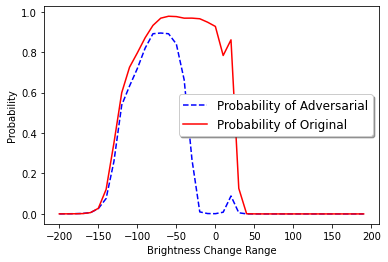

In [33]:
import matplotlib.pyplot as plt
#综合分析亮度对 对抗样本和正常图片分类的影响
std_range = range(-200,200,10)
original_pro = []
adv_pro = []

for i in std_range:
    
    brightness_adv_img=np.clip((adv.copy()+i),0,255)
    
    pro_388=infer_img(brightness_adv_img.copy(),388) 
    adv_pro+= [pro_388]
    
    brightness_img=np.clip((orig.copy()+i),0,255)
    pro=infer_img(brightness_img.copy(),388)
    original_pro += [pro]
            
    print("std={} adv_pro[388]={} original_pro[388]={}".format(i,pro_388,pro))


fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_pro), 'b--', label='Probability of Adversarial')
ax.plot(np.array(std_range), np.array(original_pro), 'r', label='Probability of Original')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Brightness Change Range')
plt.ylabel('Probability')
plt.show()

上图表示的是不同亮度下对抗样本和原始图片被分类为原来标签的概率

std=-200 pro[388]=0.0002890772302635014 pro[288]=0.0005249745445325971
std=-190 pro[388]=0.0007236068486236036 pro[288]=0.0010079174535349011
std=-180 pro[388]=0.0012590513797476888 pro[288]=0.00106788647826761
std=-170 pro[388]=0.0022925485391169786 pro[288]=0.0011318851029500365
std=-160 pro[388]=0.006555347703397274 pro[288]=0.0010411330731585622
std=-150 pro[388]=0.026071254163980484 pro[288]=0.0013042385689914227
std=-140 pro[388]=0.0761616975069046 pro[288]=0.0011200238950550556
std=-130 pro[388]=0.25931206345558167 pro[288]=0.0009190039709210396
std=-120 pro[388]=0.5382815003395081 pro[288]=0.0006133941933512688
std=-110 pro[388]=0.632213294506073 pro[288]=0.0005713281570933759
std=-100 pro[388]=0.7188606262207031 pro[288]=0.0004102016391698271
std=-90 pro[388]=0.8196889162063599 pro[288]=0.00030880351550877094
std=-80 pro[388]=0.8909081816673279 pro[288]=0.0003604879602789879
std=-70 pro[388]=0.8943798542022705 pro[288]=0.0006632950389757752
std=-60 pro[388]=0.8908138871192932 

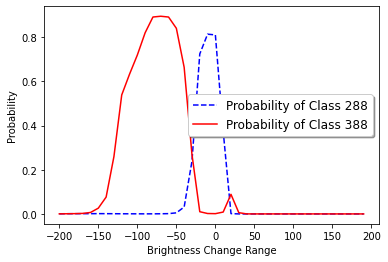

In [34]:
#验证亮度对  对抗样本的影响
std_range = range(-200,200,10)
adv_288_pro = []
adv_388_pro = []

for i in std_range:
    
    brightness_adv_img=np.clip((adv.copy()+i),0,255)
    
    pro_388=infer_img(brightness_adv_img.copy(),388)
    pro_288=infer_img(brightness_adv_img.copy(),288)
    print("std={} pro[388]={} pro[288]={}".format(i,pro_388,pro_288))
    adv_288_pro += [pro_288]
    adv_388_pro += [pro_388]

fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_288_pro), 'b--', label='Probability of Class 288')
ax.plot(np.array(std_range), np.array(adv_388_pro), 'r', label='Probability of Class 388')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Brightness Change Range')
plt.ylabel('Probability')
plt.show()

上图表示在不同亮度表现下 对抗样本被分类成class 288和class 388的概率

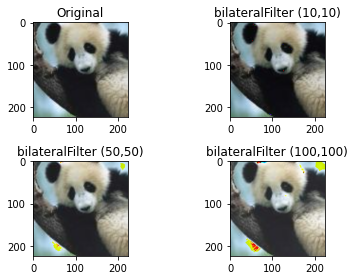

In [35]:
#展示亮度的效果
def show_brightness():
    img2=np.clip((orig.copy()-10),0,255)
    img3=np.clip((orig.copy()+10),0,255)
    img4=np.clip((orig.copy()+20),0,255)


    plt.subplot(221)
    plt.imshow(orig,cmap=plt.cm.gray) 
    plt.title("Original")

    plt.subplot(222)
    plt.imshow(img2,cmap=plt.cm.gray) 
    plt.title("bilateralFilter (10,10)")

    plt.subplot(223)
    plt.imshow(img3,cmap=plt.cm.gray) 
    plt.title("bilateralFilter (50,50)")

    plt.subplot(224)
    plt.imshow(img4,cmap=plt.cm.gray) 
    plt.title("bilateralFilter (100,100)")

    plt.tight_layout()


show_brightness()

std=0.1 pro[388]=0.0006130668916739523 pro[288]=0.0003202047955710441
std=0.2 pro[388]=0.1297655999660492 pro[288]=0.000260262459050864
std=0.30000000000000004 pro[388]=0.4127117097377777 pro[288]=0.0002373431489104405
std=0.4 pro[388]=0.45655182003974915 pro[288]=0.0008878723019734025
std=0.5 pro[388]=0.3849281668663025 pro[288]=0.007814649492502213
std=0.6 pro[388]=0.20869916677474976 pro[288]=0.06575514376163483
std=0.7000000000000001 pro[388]=0.06451040506362915 pro[288]=0.260762095451355
std=0.8 pro[388]=0.014773450791835785 pro[288]=0.5223976969718933
std=0.9 pro[388]=0.0033779682125896215 pro[288]=0.7161909341812134
std=1.0 pro[388]=0.0011697834124788642 pro[288]=0.8098616003990173
std=1.1 pro[388]=0.001417461084201932 pro[288]=0.8110589385032654
std=1.2000000000000002 pro[388]=0.004240755457431078 pro[288]=0.6830229759216309
std=1.3000000000000003 pro[388]=0.027020173147320747 pro[288]=0.27453702688217163
std=1.4000000000000001 pro[388]=0.05624476075172424 pro[288]=0.0746767148

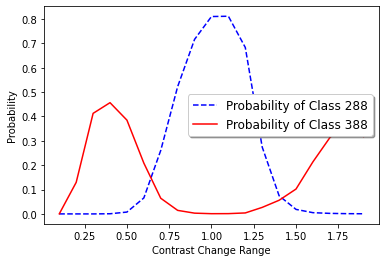

In [36]:
#验证对比度对  对抗样本的影响
std_range = np.arange(0.1,2.0,0.1)
adv_288_pro = []
adv_388_pro = []

for i in std_range:
    
    contrast_adv_img=np.clip((adv.copy()*i),0,255)
    
    pro_388=infer_img(contrast_adv_img.copy(),388)
    pro_288=infer_img(contrast_adv_img.copy(),288)
    print("std={} pro[388]={} pro[288]={}".format(i,pro_388,pro_288))
    adv_288_pro += [pro_288]
    adv_388_pro += [pro_388]

fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_288_pro), 'b--', label='Probability of Class 288')
ax.plot(np.array(std_range), np.array(adv_388_pro), 'r', label='Probability of Class 388')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Contrast Change Range')
plt.ylabel('Probability')
plt.show()

std=0.1 adv_pro[388]=0.0006130668916739523 original_pro[388]=0.0009521537576802075
std=0.2 adv_pro[388]=0.1297655999660492 original_pro[388]=0.27175143361091614
std=0.30000000000000004 adv_pro[388]=0.4127117097377777 original_pro[388]=0.7443436980247498
std=0.4 adv_pro[388]=0.45655182003974915 original_pro[388]=0.8827028870582581
std=0.5 adv_pro[388]=0.3849281668663025 original_pro[388]=0.9346514344215393
std=0.6 adv_pro[388]=0.20869916677474976 original_pro[388]=0.9409318566322327
std=0.7000000000000001 adv_pro[388]=0.06451040506362915 original_pro[388]=0.9410598278045654
std=0.8 adv_pro[388]=0.014773450791835785 original_pro[388]=0.940309464931488
std=0.9 adv_pro[388]=0.0033779682125896215 original_pro[388]=0.9355201721191406
std=1.0 adv_pro[388]=0.0011697834124788642 original_pro[388]=0.9270510673522949
std=1.1 adv_pro[388]=0.001417461084201932 original_pro[388]=0.9383842349052429
std=1.2000000000000002 adv_pro[388]=0.004240755457431078 original_pro[388]=0.9616857767105103
std=1.300

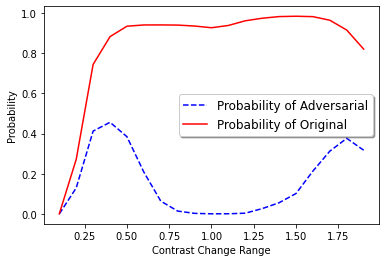

In [37]:
import matplotlib.pyplot as plt
#综合分析对比度对 对抗样本和正常图片分类的影响
std_range = np.arange(0.1,2.0,0.1)
original_pro = []
adv_pro = []

for i in std_range:
    
    contrast_adv_img=np.clip((adv.copy()*i),0,255)
    
    pro_388=infer_img(contrast_adv_img.copy(),388) 
    adv_pro+= [pro_388]
    
    contrast_img=np.clip((orig.copy()*i),0,255)
    pro=infer_img(contrast_img.copy(),388)
    original_pro += [pro]
            
    print("std={} adv_pro[388]={} original_pro[388]={}".format(i,pro_388,pro))


fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_pro), 'b--', label='Probability of Adversarial')
ax.plot(np.array(std_range), np.array(original_pro), 'r', label='Probability of Original')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Contrast Change Range')
plt.ylabel('Probability')
plt.show()